```{contents}
```
## Dynamic Graph

A **Dynamic Graph** in LangGraph is a graph whose **structure, execution path, and control flow are decided at runtime based on evolving state and model decisions**, rather than being fully fixed at compile time.
This enables **adaptive reasoning, autonomous agents, tool orchestration, and complex decision systems**.

---

### **1. Static vs Dynamic Graph**

| Feature      | Static Graph          | Dynamic Graph                      |
| ------------ | --------------------- | ---------------------------------- |
| Structure    | Fixed at compile time | Partially defined at runtime       |
| Control Flow | Pre-determined        | State-dependent                    |
| Adaptability | Low                   | High                               |
| Use Case     | Simple pipelines      | Agents, planners, decision systems |

Dynamic graphs allow the system to **change its own behavior while running**.

---

### **2. Why Dynamic Graphs Matter**

LLM systems operate in **uncertain environments**:

* User intent evolves
* Tool results are unpredictable
* Plans need revision
* Failures require recovery

Dynamic graphs let the system **re-route itself** in response.

---

### **3. Core Mechanism: State-Driven Routing**

Dynamic behavior is implemented through **router nodes** and **conditional edges**.

```python
def router(state):
    if state["need_search"]:
        return "search"
    if state["ready_to_answer"]:
        return "final"
    return "think"
```

```python
builder.add_conditional_edges(
    "router",
    router,
    {
        "search": "search_node",
        "think": "think_node",
        "final": "final_node"
    }
)
```

The graph’s **next node is chosen during execution**.

---

### **4. Runtime Structural Adaptation**

Dynamic graphs can simulate structural change by:

* Selecting different subgraphs
* Skipping nodes
* Repeating cycles
* Changing execution order

```python
if state["complex"]:
    next = "deep_reasoning"
else:
    next = "quick_answer"
```

---

### **5. Minimal Working Example**

```python
from langgraph.graph import StateGraph, END
from typing import TypedDict

class State(TypedDict):
    question: str
    need_search: bool
    answer: str

def analyze(state):
    return {"need_search": "who" in state["question"].lower()}

def search(state):
    return {"answer": "Searched information"}

def think(state):
    return {"answer": "Answered from knowledge"}

builder = StateGraph(State)

builder.add_node("analyze", analyze)
builder.add_node("search", search)
builder.add_node("think", think)

builder.set_entry_point("analyze")

builder.add_conditional_edges(
    "analyze",
    lambda s: "search" if s["need_search"] else "think",
    {"search": "search", "think": "think"}
)

builder.add_edge("search", END)
builder.add_edge("think", END)

graph = builder.compile()
print(graph.invoke({"question": "Who is Alan Turing?"}))
```

---

### **6. Common Dynamic Patterns**

| Pattern          | Description                    |
| ---------------- | ------------------------------ |
| Planner–Executor | Plan changes after each step   |
| ReAct            | Reason → Act → Observe → Route |
| Reflection       | Critique and revise            |
| Fallback         | Try alternative tools          |
| Recovery         | Re-route after failure         |
| Adaptive Search  | Change depth based on results  |

---

### **7. Production Controls**

| Control        | Purpose                |
| -------------- | ---------------------- |
| Max recursion  | Prevent infinite loops |
| Timeout        | Stop runaway execution |
| Checkpointing  | Resume after failure   |
| Tracing        | Explain decisions      |
| Human override | Manual control         |

```python
graph.invoke(input, config={"recursion_limit": 15})
```

---

### **8. When to Use Dynamic Graphs**

Use when your system must:

* Make decisions under uncertainty
* Modify plans on the fly
* Integrate unpredictable tools
* Operate autonomously

---

### **9. Mental Model**

A dynamic graph behaves like an **adaptive control system**:

> **State → Decision → Action → Feedback → Reconfiguration**

This makes LangGraph suitable for **agents, planners, multi-step reasoning, and long-running autonomous systems**.



In [1]:
from typing import TypedDict

class State(TypedDict):
    query: str
    need_search: bool
    complexity: str
    answer: str

def analyze(state: State):
    q = state["query"].lower()
    return {
        "need_search": any(w in q for w in ["who", "when", "where"]),
        "complexity": "high" if len(q.split()) > 6 else "low"
    }

def quick_answer(state: State):
    return {"answer": f"Quick answer to: {state['query']}"}

def deep_reasoning(state: State):
    return {"answer": f"Deep reasoning result for: {state['query']}"}

def search(state: State):
    return {"answer": f"Searched knowledge for: {state['query']}"}


from langgraph.graph import StateGraph, END

builder = StateGraph(State)

builder.add_node("analyze", analyze)
builder.add_node("quick", quick_answer)
builder.add_node("deep", deep_reasoning)
builder.add_node("search", search)

builder.set_entry_point("analyze")


def router(state: State):
    if state["need_search"]:
        return "search"
    if state["complexity"] == "high":
        return "deep"
    return "quick"

builder.add_conditional_edges(
    "analyze",
    router,
    {
        "search": "search",
        "deep": "deep",
        "quick": "quick"
    }
)

builder.add_edge("search", END)
builder.add_edge("deep", END)
builder.add_edge("quick", END)

graph = builder.compile()


In [2]:
print(graph.invoke({"query": "What is LangGraph?"}))
print(graph.invoke({"query": "Explain reinforcement learning with examples"}))
print(graph.invoke({"query": "2+2"}))


{'query': 'What is LangGraph?', 'need_search': False, 'complexity': 'low', 'answer': 'Quick answer to: What is LangGraph?'}
{'query': 'Explain reinforcement learning with examples', 'need_search': False, 'complexity': 'low', 'answer': 'Quick answer to: Explain reinforcement learning with examples'}
{'query': '2+2', 'need_search': False, 'complexity': 'low', 'answer': 'Quick answer to: 2+2'}


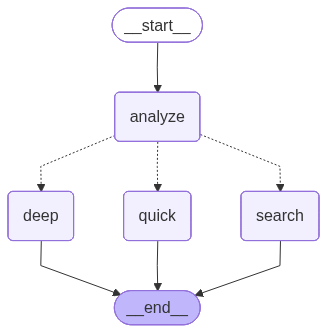

In [4]:
from IPython.display import display, Image
Image(graph.get_graph().draw_mermaid_png())